In [1]:
#import packages
import tensorflow as tf
from tensorflow.keras import Input, Model, models, layers
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randrange, sample

In [24]:
# Load data
import mne
raw = mne.io.read_raw_edf('../EEG_recordings/346/Default_2022-09-21_10_00_27_export_346.edf', preload=True)
#downsample
raw.resample(128)
sf = raw.info['sfreq']
print('Chan =', raw.ch_names)
print('Sampling frequency =', sf)
print('Data shape (channels, times) =', raw._data.shape)
# (128*60*60*23)+(128*60*30)+(128*20) #23hrs + 30min + 20sec
#load sleep scores
scores = pd.read_csv('d:/makinson_lab/sleep/EEG_recordings/346/Default_2022-09-21_10_00_27_export_346_scores.tsv', sep='\t')
# in sirenia sleep, 255 unscored, 1 wake, 2 NREM, 3 REM, 4 "parameters"
# in Yasa -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 2 = N2 sleep, 3 = N3 sleep, 4 = REM sleep
# for sleep scoring code -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 1 = N2 sleep, 1 = N3 sleep, 2 = REM sleep
scores_array = scores['scores']
scores_converted = []
for x in range(scores_array.shape[0]):
    if scores_array[x]==1: # wake
        scores_converted.append(0)
    elif scores_array[x]==2: # NREM
        scores_converted.append(1)
    elif scores_array[x]==3: # REM
        scores_converted.append(2)
    elif scores_array[x]==255: # unscored
        scores_converted.append(-2)
all_scores = scores_converted[0:4384] # 4384: total number of epochs
array_scores = np.array(all_scores).reshape(4384,1)

Extracting EDF parameters from D:\Makinson_lab\sleep\EEG_recordings\346\Default_2022-09-21_10_00_27_export_346.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 86650879  =      0.000 ... 84619.999 secs...
Chan = ['EEG EEG1.1A-B', 'EEG EEG2.1A-B', 'EMG EEG3.1A-B']
Sampling frequency = 128.0
Data shape (channels, times) = (3, 10831360)


In [25]:
CH1 = []
CH2 = []
CH3 = []
for i in range(len(all_scores)): # chunking into 10 second arrays
    CH1.append(raw._data[0][i*1280:(i+1)*1280])
    CH2.append(raw._data[1][i*1280:(i+1)*1280])
    CH3.append(raw._data[2][i*1280:(i+1)*1280])
scores_list = array_scores.tolist()

In [26]:
# next three cells are to randomize 60/20/20% 10s chunks into training, dev and test sets
train_CH1 = []
train_CH2 = []
train_CH3 = []
train_scores = []
list_of_numbers = list(range(4384))
for i in range(2630): #60% of 4384
    num = list_of_numbers.pop(randrange(len(list_of_numbers)))
    train_CH1.append(CH1[num])
    train_CH2.append(CH2[num])
    train_CH3.append(CH3[num])
    train_scores.append(scores_list[num])

In [27]:
dev_CH1 = []
dev_CH2 = []
dev_CH3 = []
dev_scores = []
for i in range(877): #20% of 4384
    num = list_of_numbers.pop(randrange(len(list_of_numbers)))
    dev_CH1.append(CH1[num])
    dev_CH2.append(CH2[num])
    dev_CH3.append(CH3[num])
    dev_scores.append(scores_list[num])

In [28]:
test_CH1 = []
test_CH2 = []
test_CH3 = []
test_scores = []
for i in range(877): #20% of 4384
    num = list_of_numbers.pop(randrange(len(list_of_numbers)))
    test_CH1.append(CH1[num])
    test_CH2.append(CH2[num])
    test_CH3.append(CH3[num])
    test_scores.append(scores_list[num])

In [7]:
# train_CH1_check = np.array(CH1[0:2629])
# train_CH2_check = np.array(CH2[0:2629])
# train_CH3_check = np.array(CH3[0:2629])

# dev_CH1_check = np.array(CH1[2629:3505])
# dev_CH2_check = np.array(CH2[2629:3505])
# dev_CH3_check = np.array(CH3[2629:3505])

# test_CH1_check = np.array(CH1[3505:4384])
# test_CH2_check = np.array(CH2[3505:4384])
# test_CH3_check = np.array(CH3[3505:4384])

# train_scores_check = array_scores[0:2629]
# dev_scores_check = array_scores[2629:3505]
# test_scores_check = array_scores[3505:4384]

In [7]:
def get_uncompiled_model():
    input_EEG = Input(shape=(1280,), name = 'EEG')
    input_EMG = Input(shape=(1280,), name = 'EMG')
    inputs = layers.concatenate([input_EEG, input_EMG], name = 'combined_inputs')
    x = layers.Dense(9, activation = "relu", name = 'layer_1')(inputs)
    x = layers.Dense(3, activation = "relu", name = 'layer_2')(x)
    outputs = layers.Dense(3, activation = "linear", name = 'outputs')(x)
    model = Model(inputs = [input_EEG, input_EMG], outputs = [outputs], name = 'sleep_scoring_model')
    return model

def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ["accuracy"],
    )
    return model

In [8]:
model = get_compiled_model()

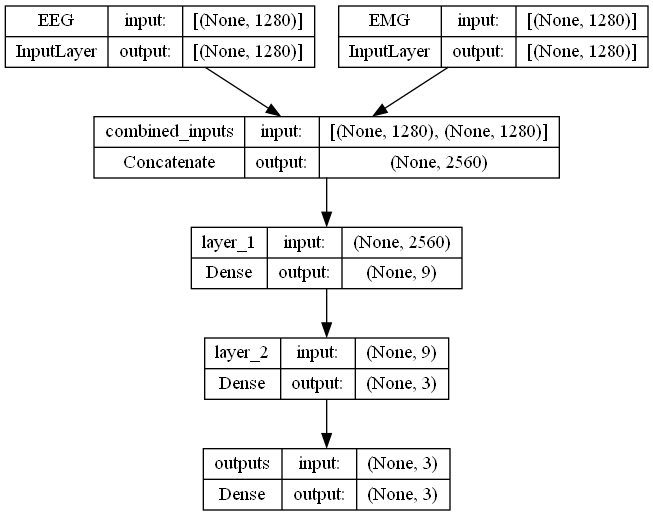

In [9]:
plot_model(model, 'multi_input_neural_network.png', show_shapes=True, show_layer_names=True)

In [10]:
model.summary()

Model: "sleep_scoring_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EEG (InputLayer)               [(None, 1280)]       0           []                               
                                                                                                  
 EMG (InputLayer)               [(None, 1280)]       0           []                               
                                                                                                  
 combined_inputs (Concatenate)  (None, 2560)         0           ['EEG[0][0]',                    
                                                                  'EMG[0][0]']                    
                                                                                                  
 layer_1 (Dense)                (None, 9)            23049       ['combined_inpu

In [11]:
EEG = []
for array in train_CH1:
    max_abs = max(abs(array))
    EEG.append(array/max_abs)
X_EEG = np.array(EEG)

EMG = []
for array in train_CH3:
    max_abs = max(abs(array))
    EMG.append(array/max_abs)
X_EMG = np.array(EMG)

y = np.array(train_scores)

In [12]:

history = model.fit({'EEG':X_EEG, 'EMG': X_EMG},
                    {'outputs': y},
    epochs=1000
)

Epoch 1/1000
83/83 [==============================] - 1s 2ms/step - loss: 0.7950 - accuracy: 0.6335
Epoch 2/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.6214 - accuracy: 0.7890
Epoch 3/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.5476 - accuracy: 0.8312
Epoch 4/1000
83/83 [==============================] - 0s 1ms/step - loss: 0.4946 - accuracy: 0.8665
Epoch 5/1000
83/83 [==============================] - 0s 1ms/step - loss: 0.4545 - accuracy: 0.8833
Epoch 6/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.4212 - accuracy: 0.8916
Epoch 7/1000
83/83 [==============================] - 0s 1ms/step - loss: 0.3946 - accuracy: 0.8989
Epoch 8/1000
83/83 [==============================] - 0s 1ms/step - loss: 0.3751 - accuracy: 0.9004
Epoch 9/1000
83/83 [==============================] - 0s 1ms/step - loss: 0.3595 - accuracy: 0.9008
Epoch 10/1000
83/83 [==============================] - 0s 1ms/step - loss: 0.3474 - accuracy: 0.9011

83/83 [==============================] - 0s 2ms/step - loss: 0.2438 - accuracy: 0.9019
Epoch 83/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2422 - accuracy: 0.9023
Epoch 84/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2404 - accuracy: 0.9023
Epoch 85/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2396 - accuracy: 0.9023
Epoch 86/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2382 - accuracy: 0.9023
Epoch 87/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2360 - accuracy: 0.9019
Epoch 88/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2343 - accuracy: 0.9023
Epoch 89/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2343 - accuracy: 0.9023
Epoch 90/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2330 - accuracy: 0.9019
Epoch 91/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2318 - accuracy: 0.9023
Epoc

83/83 [==============================] - 0s 2ms/step - loss: 0.1605 - accuracy: 0.9042
Epoch 163/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1604 - accuracy: 0.9042
Epoch 164/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1602 - accuracy: 0.9042
Epoch 165/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1601 - accuracy: 0.9042
Epoch 166/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1597 - accuracy: 0.9042
Epoch 167/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1596 - accuracy: 0.9042
Epoch 168/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1594 - accuracy: 0.9042
Epoch 169/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1593 - accuracy: 0.9042
Epoch 170/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.9042
Epoch 171/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.

83/83 [==============================] - 0s 2ms/step - loss: 0.1228 - accuracy: 0.9274
Epoch 243/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1228 - accuracy: 0.9274
Epoch 244/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1226 - accuracy: 0.9274
Epoch 245/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1225 - accuracy: 0.9274
Epoch 246/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1225 - accuracy: 0.9274
Epoch 247/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.9274
Epoch 248/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.9274
Epoch 249/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1222 - accuracy: 0.9274
Epoch 250/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1215 - accuracy: 0.9281
Epoch 251/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.1252 - accuracy: 0.

83/83 [==============================] - 0s 2ms/step - loss: 0.0989 - accuracy: 0.9483
Epoch 323/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0988 - accuracy: 0.9487
Epoch 324/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0987 - accuracy: 0.9483
Epoch 325/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0986 - accuracy: 0.9487
Epoch 326/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0985 - accuracy: 0.9487
Epoch 327/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0985 - accuracy: 0.9483
Epoch 328/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.0985 - accuracy: 0.9487
Epoch 329/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.0984 - accuracy: 0.9487
Epoch 330/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0983 - accuracy: 0.9487
Epoch 331/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.0983 - accuracy: 0.

83/83 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9540
Epoch 403/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9540
Epoch 404/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9540
Epoch 405/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9540
Epoch 406/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9540
Epoch 407/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9540
Epoch 408/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9540
Epoch 409/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9540
Epoch 410/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9540
Epoch 411/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0918 - accuracy: 0.

83/83 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.9639
Epoch 483/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.9639
Epoch 484/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0777 - accuracy: 0.9639
Epoch 485/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0776 - accuracy: 0.9639
Epoch 486/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0776 - accuracy: 0.9639
Epoch 487/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0776 - accuracy: 0.9639
Epoch 488/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.9639
Epoch 489/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.9639
Epoch 490/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.9639
Epoch 491/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.

83/83 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9673
Epoch 563/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9673
Epoch 564/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9673
Epoch 565/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9673
Epoch 566/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9673
Epoch 567/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9673
Epoch 568/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9673
Epoch 569/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9673
Epoch 570/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9673
Epoch 571/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.0725 - accuracy: 0.

83/83 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9722
Epoch 643/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9722
Epoch 644/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9722
Epoch 645/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9722
Epoch 646/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9722
Epoch 647/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9722
Epoch 648/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.9722
Epoch 649/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9722
Epoch 650/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0655 - accuracy: 0.9722
Epoch 651/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 0.

83/83 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9764
Epoch 723/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9764
Epoch 724/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9764
Epoch 725/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9764
Epoch 726/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9764
Epoch 727/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9764
Epoch 728/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9764
Epoch 729/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9764
Epoch 730/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.9764
Epoch 731/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.

83/83 [==============================] - 0s 3ms/step - loss: 0.0589 - accuracy: 0.9764
Epoch 803/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.0589 - accuracy: 0.9764
Epoch 804/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.0589 - accuracy: 0.9764
Epoch 805/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.0589 - accuracy: 0.9764
Epoch 806/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0590 - accuracy: 0.9764
Epoch 807/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0589 - accuracy: 0.9764
Epoch 808/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0589 - accuracy: 0.9764
Epoch 809/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0589 - accuracy: 0.9764
Epoch 810/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0589 - accuracy: 0.9764
Epoch 811/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0589 - accuracy: 0.

83/83 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9787
Epoch 883/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9787
Epoch 884/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9787
Epoch 885/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9787
Epoch 886/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9787
Epoch 887/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9787
Epoch 888/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9787
Epoch 889/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9787
Epoch 890/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.9787
Epoch 891/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.

83/83 [==============================] - 0s 2ms/step - loss: 0.0513 - accuracy: 0.9810
Epoch 963/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9810
Epoch 964/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9810
Epoch 965/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9810
Epoch 966/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0513 - accuracy: 0.9810
Epoch 967/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9810
Epoch 968/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9810
Epoch 969/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9810
Epoch 970/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0513 - accuracy: 0.9810
Epoch 971/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.

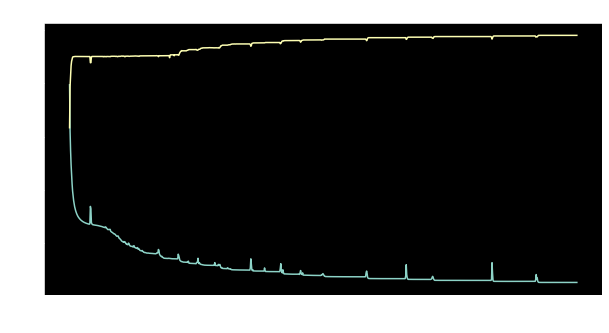

In [13]:
fig = plt.figure(figsize = [10,5])
plt.style.use('dark_background')
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.title('Learning Curve')
plt.show()

In [36]:
EEG = []
for array in test_CH1:
    max_abs = max(abs(array))
    EEG.append(array/max_abs)
X_EEG = np.array(EEG)

EMG = []
for array in test_CH3:
    max_abs = max(abs(array))
    EMG.append(array/max_abs)
X_EMG = np.array(EMG)

y = np.array(test_scores)

In [39]:
dev_scores = model.evaluate(x=[X_EEG,X_EMG],
                            y=y, 
                           verbose = 2
                           )

28/28 - 0s - loss: 2.1933 - accuracy: 0.8883 - 59ms/epoch - 2ms/step


In [42]:
# model.save('test_model')

INFO:tensorflow:Assets written to: test_model\assets


INFO:tensorflow:Assets written to: test_model\assets


In [169]:
train_EEG = np.array(train_CH1)
train_EMG = np.array(train_CH3)
train_y = np.array(train_scores)
# for sleep scoring code -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 1 = N2 sleep, 1 = N3 sleep, 2 = REM sleep
y_hat = []
for x in range(train_EEG.shape[0]):
    prediction = model.predict([train_EEG[x].reshape(1,1280), train_EMG[x].reshape(1,1280)])
    prediction_p = tf.nn.softmax(prediction)
    y_hat.append(np.argmax(prediction_p))
yhat = np.array(y_hat).reshape(len(y_hat),1)
equals = yhat==train_y
sum(equals)/len(y_hat)

In [172]:
dev_EEG = np.array(dev_CH1)
dev_EMG = np.array(dev_CH3)
dev_y = np.array(dev_scores)
# for sleep scoring code -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 1 = N2 sleep, 1 = N3 sleep, 2 = REM sleep
y_hat = []
for x in range(dev_EEG.shape[0]):
    prediction = model.predict([dev_EEG[x].reshape(1,1280), dev_EMG[x].reshape(1,1280)])
    prediction_p = tf.nn.softmax(prediction)
    y_hat.append(np.argmax(prediction_p))
yhat = np.array(y_hat).reshape(len(y_hat),1)
equals = yhat==dev_y
sum(equals)/len(y_hat)

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


array([0.65906499])